Autograd - implements backpropagation (algorithm that efficiently evaluates the gradient of a loss function with respect to the weights). 
We can use it to tune the weights to minimize the loss.

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The value object:

In [27]:
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        return Value(self.data + other.data)
    # so when we add a + b, Python will internally call a.__add__(b)
    def __mul__(self, other):
        return Value(self.data * other.data)

To not overcomplicate the code above, I'm going to copy and paste it in another cell and modify:

In [28]:
# To visualize:
class Value:
    # private empty tuple
    # now when we create a value object, children will be empty and prev will be empty set
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)
            
    def __repr__(self):
        return f"Value(data={self.data})"

    # when we multiply, the children will be a tuple consisting of self and other
    def __add__(self, other):
        return Value(self.data + other.data, (self, other))
        
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other))

In [29]:
a = Value(2.0)
b = Value(-3.0)
c = a * b
c._prev

{Value(data=-3.0), Value(data=2.0)}

We know the children but don't know the operation that created it, so we modify the class again:

In [30]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''): # by default an empty string
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
            
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
        
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [31]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a * b; c.label = 'c'
c._op

'*'

VISUALIZATION PART:

In [32]:
from graphviz import Digraph

def trace(root): # build a set of all nodes and edjes in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR meaning left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular node for it
        dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
        if n._op: # if the value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

# We basically create special node objects using .node() and edges using .edge

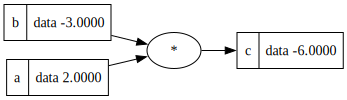

In [33]:
draw_dot(c)

In [34]:
# Make it more complicated:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

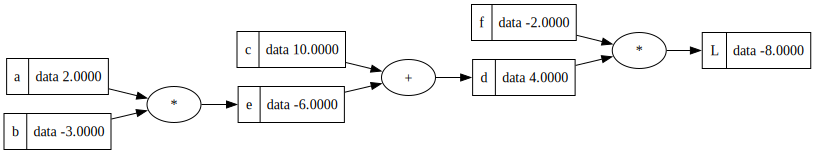

In [35]:
draw_dot(L)
# visualization of the forward pass (from left to right):

To do backprop, we start at L and calculate the gradients along all the intermediate values.
So find the derivatives of L with respect to the weights of the neural network (a, b, e, c, f, d)
Now, let's add the gradient:

In [36]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 # set to 0 by default, means that changing a variable doesn't change the loss function
        self._prev = set(_children)
        self._op = _op
        self.label = label
            
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
        
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [37]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR meaning left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot
draw_dot(L)

Filling in the gradients for L, d, and f: 

In [38]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data

In [39]:
draw_dot(L)

AttributeError: 'Value' object has no attribute 'grad'

Now we need to derive dL/dc. We know that dd/dc = 1.0 and dd/de = 1.0 because there's an addition (d = c + e).
Then we apply the chain rule to get dL/dc.

dL/dc = (dL/dd) * (dd/dc) = -2.0 * 1.0 = -2.0

The plus nodes just route the gradient because their local derivative is 1.

In [ ]:
c.grad = d.grad
e.grad = d.grad
draw_dot(L)

Next: dL/da - ?
dL/da = dL/de * de/da = -2 * -3 = 6

In [ ]:
a.grad = b.data * e.grad
b.grad = a.data * e.grad
draw_dot(L)